# Preprocess

## Read csv to dataframe

use pandas to read data

In [1]:
import pandas as pd
df = pd.read_csv('./201707-citibike-tripdata.csv')
df

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,364,2017-07-01 00:00:00,2017-07-01 00:06:05,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,3107,Bedford Ave & Nassau Ave,40.723117,-73.952123,14744,Subscriber,1986.0,1
1,2142,2017-07-01 00:00:03,2017-07-01 00:35:46,293,Lafayette St & E 8 St,40.730207,-73.991026,3425,2 Ave & E 104 St,40.789210,-73.943708,19587,Subscriber,1981.0,1
2,328,2017-07-01 00:00:08,2017-07-01 00:05:37,3242,Schermerhorn St & Court St,40.691029,-73.991834,3397,Court St & Nelson St,40.676395,-73.998699,27937,Subscriber,1984.0,2
3,2530,2017-07-01 00:00:11,2017-07-01 00:42:22,2002,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,398,Atlantic Ave & Furman St,40.691652,-73.999979,26066,Subscriber,1985.0,1
4,2534,2017-07-01 00:00:15,2017-07-01 00:42:29,2002,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,398,Atlantic Ave & Furman St,40.691652,-73.999979,29408,Subscriber,1982.0,2
5,545,2017-07-01 00:00:18,2017-07-01 00:09:24,361,Allen St & Hester St,40.716059,-73.991908,502,Henry St & Grand St,40.714215,-73.981346,21203,Subscriber,1954.0,2
6,1496,2017-07-01 00:00:18,2017-07-01 00:25:15,3233,E 48 St & 5 Ave,40.757246,-73.978059,546,E 30 St & Park Ave S,40.744449,-73.983035,15933,Customer,1971.0,1
7,1495,2017-07-01 00:00:19,2017-07-01 00:25:15,3233,E 48 St & 5 Ave,40.757246,-73.978059,546,E 30 St & Park Ave S,40.744449,-73.983035,18515,Customer,1964.0,2
8,593,2017-07-01 00:00:27,2017-07-01 00:10:20,3314,W 95 St & Broadway,40.793770,-73.971888,3363,E 102 St & Park Ave,40.790483,-73.950331,29135,Subscriber,1982.0,1
9,1950,2017-07-01 00:00:30,2017-07-01 00:33:00,3085,Roebling St & N 4 St,40.714690,-73.957390,468,Broadway & W 56 St,40.765265,-73.981923,17365,Subscriber,1983.0,1


## Detect missing data

find out some null or NAN in dataframe, and we find NAN in birth year column

In [2]:
df.isnull().any()

tripduration               False
starttime                  False
stoptime                   False
start station id           False
start station name         False
start station latitude     False
start station longitude    False
end station id             False
end station name           False
end station latitude       False
end station longitude      False
bikeid                     False
usertype                   False
birth year                  True
gender                     False
dtype: bool

## Fill missing data with the most frequency data

because birth year is not like real number, we do not use mean to fill missing data; using the most frequency data is more proper to fix it

In [3]:
df['birth year'] = df['birth year'].fillna(df['birth year'].mode()[0])
df.isnull().any()

tripduration               False
starttime                  False
stoptime                   False
start station id           False
start station name         False
start station latitude     False
start station longitude    False
end station id             False
end station name           False
end station latitude       False
end station longitude      False
bikeid                     False
usertype                   False
birth year                 False
gender                     False
dtype: bool

## Detect strange trip duration

trip duration should not be negtive

In [4]:
(df['tripduration'] < 0).any()

False

## Detect strange station id and bikeid

id is usually not minus number

In [5]:
print (df['start station id'] < 0).any()
print (df['end station id'] < 0).any()
print (df['bikeid'] < 0).any()

False
False
False


## Detect strange usertype and gender

check the values of usertype and gender are in spec

In [6]:
print set(df['usertype'])
print set(df['gender'])

set(['Subscriber', 'Customer'])
set([0, 1, 2])


## Translate time to every hour stamp and detect strange time

make in_flow and out_flow generate more easily, so we translate time to timestamp that repersents how many hours from 2017-07-01 00:00:00; and also check timestamp should be positive

In [7]:
from datetime import datetime

def timestamp(df):
    tmp = []
    t0 = datetime(2017, 7, 1, 0, 0)
    for row in df.itertuples():
        t1 = datetime.strptime(row[1], '%Y-%m-%d %H:%M:%S')
        tm = int((t1 - t0).total_seconds() // 1800)
        assert tm >= 0
        tmp.append(tm)
    df.insert(loc = 0, column = 'timestamp', value = tmp)

start_df = df[['starttime', 'start station id']]
timestamp(start_df)
end_df = df[['stoptime', 'end station id']]
timestamp(end_df)
# start_df
end_df

,timestamp,stoptime,end station id
0,0,2017-07-01 00:06:05,3107
1,1,2017-07-01 00:35:46,3425
2,0,2017-07-01 00:05:37,3397
3,1,2017-07-01 00:42:22,398
4,1,2017-07-01 00:42:29,398
5,0,2017-07-01 00:09:24,502
6,0,2017-07-01 00:25:15,546
7,0,2017-07-01 00:25:15,546
8,0,2017-07-01 00:10:20,3363
9,1,2017-07-01 00:33:00,468


## Calculate station number

append two columns and put them into set, so we can use len function to know the station number

In [8]:
station_id = list(set(df['start station id'].tolist() + df['end station id'].tolist()))
station_num = len(station_id)
station_num

634

## Calculate in_flow and out_flow

use end_df and start_df to sum every timestamp, and the outcome is in_flow and out_flow

In [9]:
import numpy as np

def cnt_flow(df):
    flow = pd.DataFrame(np.zeros((48 * 31, station_num)), columns = station_id)
    for row in df.itertuples():
        if row[1] < 48 * 31:
            flow.loc[row[1], row[3]] += 1
    return flow

in_flow = cnt_flow(end_df)
out_flow = cnt_flow(start_df)
in_flow.to_csv('in_flow.csv')
out_flow.to_csv('out_flow.csv')
out_flow


,72,79,82,83,116,119,120,127,128,143,...,2003,2005,2006,2008,2009,2010,2012,2021,2022,2023
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,...,0.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Query

## 1. How many stations are there in this dataset, and what is the average distance between them?

there are 634 stations and the average distance between them is 10877.7798769 meters

In [10]:
start_station = df[['start station id', 'start station name', 'start station latitude', 'start station longitude']]
start_station.columns = ['station id', 'station name', 'station latitude', 'station logitude']
end_station = df[['end station id', 'end station name', 'end station latitude', 'end station longitude']]
end_station.columns = ['station id', 'station name', 'station latitude', 'station logitude']

station = start_station.append(end_station, ignore_index = True)
station = station.drop_duplicates()
station = station.reset_index(drop = True)
station_num = len(station)
station

,station id,station name,station latitude,station logitude
0,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241
1,293,Lafayette St & E 8 St,40.730207,-73.991026
2,3242,Schermerhorn St & Court St,40.691029,-73.991834
3,2002,Wythe Ave & Metropolitan Ave,40.716887,-73.963198
4,361,Allen St & Hester St,40.716059,-73.991908
5,3233,E 48 St & 5 Ave,40.757246,-73.978059
6,3314,W 95 St & Broadway,40.793770,-73.971888
7,3085,Roebling St & N 4 St,40.714690,-73.957390
8,382,University Pl & E 14 St,40.734927,-73.992005
9,305,E 58 St & 3 Ave,40.760958,-73.967245


use great circle to calculate distance

In [11]:
from geopy.distance import great_circle

dist_sum = 0
for i in xrange(station_num):
    for j in xrange(station_num):
        if i != j:
            a = (station.iloc[i, 2], station.iloc[i, 3])
            b = (station.iloc[j, 2], station.iloc[j, 3])
            dist_sum += great_circle(a, b).meters

print dist_sum / float(station_num * (station_num - 1) / 2)

10877.7798769


## 2. What are the top 3 frequent stations pairs (start stations, end stations) in weekdays, how about in weekends?

represent station by station id

- weekdays
    1. (432, 3263) 656
    2. (2006, 2006) 547
    3. (281, 281) 499


- weekends
    1. (3182, 3182) 889
    2. (3182, 3254) 829
    3. (3254, 3182) 818

In [12]:
pair_station = df[['start station id', 'end station id', 'starttime', 'stoptime']]
pair_station

,start station id,end station id,starttime,stoptime
0,539,3107,2017-07-01 00:00:00,2017-07-01 00:06:05
1,293,3425,2017-07-01 00:00:03,2017-07-01 00:35:46
2,3242,3397,2017-07-01 00:00:08,2017-07-01 00:05:37
3,2002,398,2017-07-01 00:00:11,2017-07-01 00:42:22
4,2002,398,2017-07-01 00:00:15,2017-07-01 00:42:29
5,361,502,2017-07-01 00:00:18,2017-07-01 00:09:24
6,3233,546,2017-07-01 00:00:18,2017-07-01 00:25:15
7,3233,546,2017-07-01 00:00:19,2017-07-01 00:25:15
8,3314,3363,2017-07-01 00:00:27,2017-07-01 00:10:20
9,3085,468,2017-07-01 00:00:30,2017-07-01 00:33:00


In [13]:
pair = {}
for row in pair_station.itertuples():
    d = datetime.strptime(row[3], '%Y-%m-%d %H:%M:%S')
    d = 'weekday' if d.isoweekday() < 6 else 'weekend'
    if pair.get((row[1], row[2], d)):
        pair[(row[1], row[2], d)] += 1
    else:
        pair[(row[1], row[2], d)] = 1
pair = sorted(pair.items(), key=lambda d: d[1])
end_cnt = 0
day_cnt = 0
for key, val in pair[::-1]:
    if end_cnt >= 3 and day_cnt >= 3:
        break
    if 'weekend' in key and end_cnt < 3:
        end_cnt += 1
        print key, val
    if 'weekday' in key and day_cnt < 3:
        day_cnt += 1
        print key, val

(3182, 3182, 'weekend') 889
(3182, 3254, 'weekend') 829
(3254, 3182, 'weekend') 818
(432, 3263, 'weekday') 656
(2006, 2006, 'weekday') 547
(281, 281, 'weekday') 499


## 3. Find the top 3 stations with highest average out-flow, and top 3 highest average in-flow

represent station by station id

### Top 3 stations with highest average out-flow

In [14]:
mean_out_flow = pd.DataFrame(out_flow.mean().tolist(), station_id, columns = ['average flow'])
mean_out_flow.nlargest(3, 'average flow')

,average flow
519,9.981855
426,9.487903
514,8.241263


### Top 3 stations with highest average in-flow

In [15]:
mean_in_flow = pd.DataFrame(in_flow.mean().tolist(), station_id, columns = ['average flow'])
mean_in_flow.nlargest(3, 'average flow')

,average flow
426,9.942876
519,9.723790
514,8.528226


## 4. What is the most popular station (highest average inflow + outflow)?

In [16]:
(mean_in_flow + mean_out_flow).nlargest(1, 'average flow')

,average flow
519,19.705645


### Define function to plot picture and calculate the distance

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

def cal_and_draw(in_df, out_df):
    p_in_flow = in_df.tolist()
    p_out_flow = out_df.tolist()
    plt.figure(figsize = (16, 4))
    plt.plot(p_in_flow)
    plt.plot(p_out_flow)
    plt.show()
    print euclidean_distances(np.array(p_in_flow).reshape(1, -1), np.array(p_out_flow).reshape(1, -1))[0][0]

### Draw the in-flow(A) and out-flow(B) for that station in a line chart
### Calculate the distance function between A and B with euclidean distance

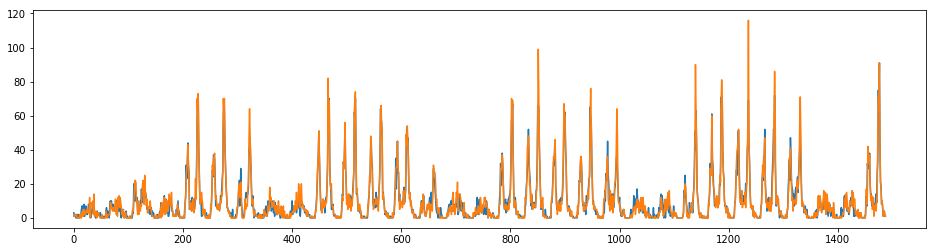

178.555313559


In [18]:
p_in_flow = in_flow[519]
p_out_flow = out_flow[519]
cal_and_draw(p_in_flow, p_out_flow)

### Calculate the distance function between A - mean(A) and B - mean(B) , and draw them both

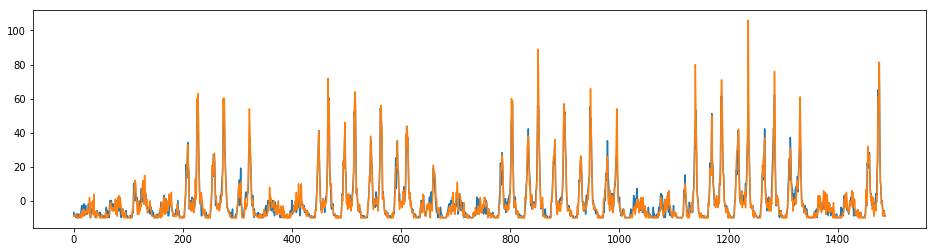

178.277601582


In [19]:
cal_and_draw(p_in_flow - p_in_flow.mean(), p_out_flow - p_out_flow.mean())

### Calculate the distance function between (A - mean(A)) / std(A) and (B - mean(B)) / std(B) , and draw them both

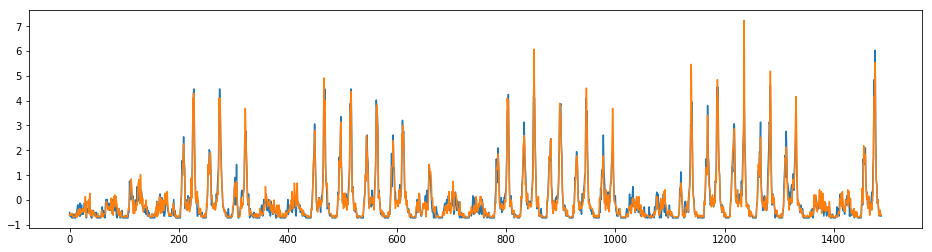

12.2769402356


In [20]:
cal_and_draw((p_in_flow - p_in_flow.mean()) / p_in_flow.std(), (p_out_flow - p_out_flow.mean()) / p_out_flow.std())

### Calculate the distance function between {Ai − f(i) | Ai ∈ A} and {Bi − f(i) | Bi ∈ B} , and draw them both

remove linear trend along axis from data with scipy.signal.detrend

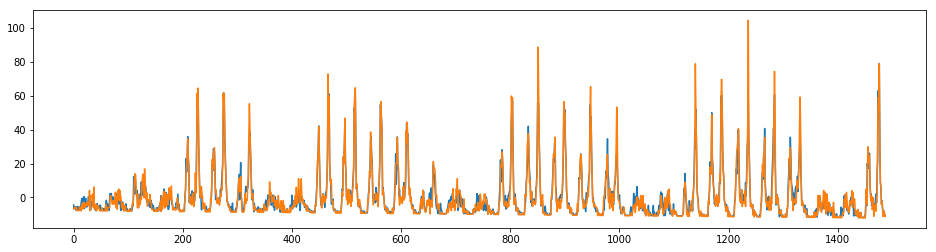

178.272088102


In [21]:
from scipy import signal
cal_and_draw(signal.detrend(p_in_flow), signal.detrend(p_out_flow))

### Calculate the distance function between Smooth(A) and Smooth(B) , and draw them both

#### Smooth with a Savitzky-Golay filter

the window-length = 5 means smooth over a 2-hour (120 minute) window

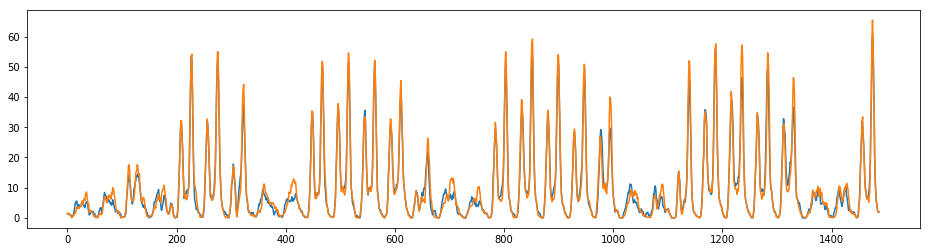

85.0315235663


In [22]:
cal_and_draw(signal.savgol_filter(p_in_flow, window_length = 5, polyorder = 0), signal.savgol_filter(p_out_flow, window_length = 5, polyorder = 0))

## 5. Please try to find some interesting query or observation in the dataset

### Calculate average trip duration with gender

- male 901.685699446 sec
- female 1017.37209273 sec
- unknown 1873.76102282 sec

In [23]:
duration_df = df[['tripduration', 'gender']]

male_sum = 0
male = 0
female_sum = 0
female = 0
unknown_sum = 0
unknown = 0

for row in duration_df.itertuples():
    gen = row[2]
    if gen == 0:
        unknown += 1
        unknown_sum += row[1]
    elif gen == 1:
        male += 1
        male_sum += row[1]
    elif gen == 2:
        female += 1
        female_sum += row[1]

print float(male_sum) / float(male)
print float(female_sum) / float(female)
print float(unknown_sum) / float(unknown)

901.685699446
1017.37209273
1873.76102282


### The station which is most females visited

represent station by station id

in 426 station, there are most females, so we can visit there often XD

In [24]:
def keywithmaxval(d):
    v = list(d.values())
    k = list(d.keys())
    return k[v.index(max(v))]

tra_df = df[['start station id', 'end station id', 'gender']]
cnt = {}
for row in tra_df.itertuples():
    if row[3] == 2:
        if cnt.get(row[1]):
            cnt[row[1]] += 1
        else:
            cnt[row[1]] = 1
        if cnt.get(row[2]):
            cnt[row[2]] += 1
        else:
            cnt[row[2]] = 1
keywithmaxval(cnt)

426